# Beer Boroughs: 
#### Finding your suds in a sea of cities



![alt text](https://upload.wikimedia.org/wikipedia/commons/f/f4/Beer_banner.jpg "Beer Taps")


## Goal: Find the West Coast city with the highest number of Breweries per Capita.  

__Target Audience:__ Anyone roaming the Best Coast who appreciates the value of quality beer.   

__Data Sources:__ Combine data from the following sources:

* US City population and lat/lon.  Datasource: https://simplemaps.com/data/us-cities
* Foursquare venue information.  Datasource: https://developer.foursquare.com/docs/api/venues/search
* Possibly some mapping data to visualize

---


# Data sources
I will pull together two data sources:  city data and foursquare venue data.  

### City Data
The City data is downloadable in .csv format from https://simplemaps.com/data/us-cities and contains 16 columns. 

It needs cleaning, but already contains the key info:  City, Lat/Lng, Timezone, and Population.  Actually nearly half of cities are missing population data here, so I'll remove those.  I'll further narrow with a population threshold (such as cities with more than 50,000 inhabitants).  The lat/lng are perfect inputs for the foursquare API.  In addition, the timezone column will help me limit this to West Coast USA cities.

Below is a quick visual of the city data. 

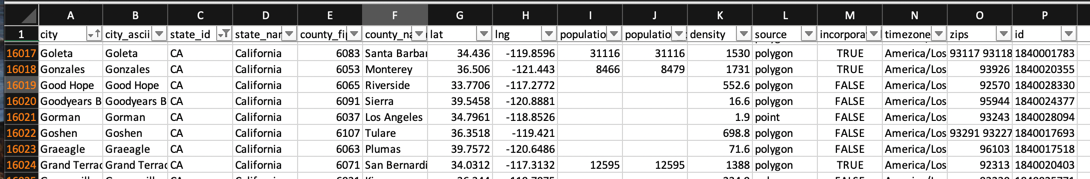

In [1]:
# @hidden_cell
from IPython.display import Image
PATH = "./"
Image(filename = PATH + "CityData.png", width=1000, height=500)

### Foursquare Data
Next, we'll be combining with foursquare data.  Foursquare offers a developer API and we'll be using its venue search functionality.  Breweries have their own category id (categoryId = '50327c8591d4c4b30a586d5d') which, in my own quick testing, seems to return more complete results than using (search_query = 'Brewery').  

I did a quick test for Breweries in the city of Goleta, CA and find it to be fairly accurate:

__Sample output__
* 0      Santa Barbara Cider Company
* 1        Hollister Brewing Company
* 2    Captain Fatty's Craft Brewery
* 3                   Rincon Brewery
* 4             Draughtsmen Aleworks
* 5        M.Special Brewing Company

### This completes the introduction to the project, datasources, and approach.  Let's begin:

----

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # libaray for arrays
from pandas.io.json import json_normalize # turns json into dataframes

# Process the city data

Let's begin by pulling in the city data CSV.  The steps are:
* Read data from csv into dataframe
* Narrow by timezone. We'll write a function for this, to allow us to easily evaluate other timezones later
* Population:
   * Remove cities with no population data
   * Remove cities below a certain threshold.  I'm thinking 80,000, but will take some iterations
   * Will write this as a function too, in case we later want to adjust city size
* Remove unneeded columns.  

__Output:__ will be a dataframe containing only cities in Pacific timezone, with populations above 80K, columns to include cityname, state, population, lat and lon. (possibly county)

In [3]:
# Get the file from local drive
filepath = "../datasets/uscitiesv1.5.csv"
read_data = pd.read_csv(filepath, dtype={'city': object})
read_data.columns = read_data.columns.str.strip()  #removes padding from city column name

print(read_data.shape)
read_data.head()

(37842, 16)


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,population_proper,density,source,incorporated,timezone,zips,id
0,Prairie Ridge,Prairie Ridge,WA,Washington,53053,Pierce,47.1443,-122.1408,NaN,NaN,1349.8,polygon,False,America/Los_Angeles,98360 98391,1840037882
1,Edison,Edison,WA,Washington,53057,Skagit,48.5602,-122.4311,NaN,NaN,127.4,polygon,False,America/Los_Angeles,98232,1840017314
2,Packwood,Packwood,WA,Washington,53041,Lewis,46.6085,-121.6702,NaN,NaN,213.9,polygon,False,America/Los_Angeles,98361,1840025265
3,Wautauga Beach,Wautauga Beach,WA,Washington,53035,Kitsap,47.5862,-122.5482,NaN,NaN,261.7,point,False,America/Los_Angeles,98366,1840037725
4,Harper,Harper,WA,Washington,53035,Kitsap,47.5207,-122.5196,NaN,NaN,342.1,point,False,America/Los_Angeles,98366,1840037659


In [4]:
# checking the population NaN's shows 18K.  We can cut our data size in half by removing them.
#print(read_data.isnull().sum())
# we'll just drop all rows with any NaNs, since the other key columns aren't missing any.
read_data.dropna(inplace=True)

In [55]:
# with more population nulls, we can make it more readable by converting to int64 to remove the .0
read_data.population = read_data.population.astype(np.int64) 

# will work with a subset of columns:
all_cities = read_data[['city', 'population', 'lat', 'lng','timezone','state_id', 'county_name']]
all_cities.head()

,city,population,lat,lng,timezone,state_id,county_name
6,Kahlotus,199,46.6437,-118.5565,America/Los_Angeles,WA,Franklin
8,Washtucna,204,46.7540,-118.3106,America/Los_Angeles,WA,Adams
10,Toledo,751,46.4412,-122.8493,America/Los_Angeles,WA,Lewis
12,Renton,101379,47.4758,-122.1905,America/Los_Angeles,WA,King
13,Chehalis,7533,46.6637,-122.9647,America/Los_Angeles,WA,Lewis


In [56]:
def choose_cities(df, timezone='America/Los_Angeles', population=80000):
    '''Purpose: narrow down cities based on:
    input:  df(dataframe) of city data, 
            timezone (string) = desired timezone (LA default),
            population (int) = minimum population of cities (80K default)
    output: new df
    '''
    df = df[df['timezone'] == timezone]
    df = df[df['population'] > population]
    df = df.reset_index(drop=True)
    return(df)

In [204]:
# Use the function above to narrow down our cities.  Print out results by state and show a few rows
cities = choose_cities(all_cities, 'America/Los_Angeles', 80000)
print(cities.shape)
print(cities.groupby('state_id').count())
cities.sort_values(['population'], ascending=False).reset_index(drop=True).head()

(146, 7)
          city  population  lat  lng  timezone  county_name
state_id                                                   
CA         114         114  114  114       114          114
ID           1           1    1    1         1            1
NV           5           5    5    5         5            5
OR           8           8    8    8         8            8
WA          18          18   18   18        18           18


,city,population,lat,lng,timezone,state_id,county_name
0,Los Angeles,12815475,34.1139,-118.4068,America/Los_Angeles,CA,Los Angeles
1,Seattle,3643765,47.6211,-122.3244,America/Los_Angeles,WA,King
2,San Francisco,3603761,37.7562,-122.4430,America/Los_Angeles,CA,San Francisco
3,San Diego,3210314,32.8312,-117.1226,America/Los_Angeles,CA,San Diego
4,Riverside,2084749,33.9381,-117.3948,America/Los_Angeles,CA,Riverside


### Our city work is done!  Now move on to find the breweries.  Getting thirsty yet?
----

# Process the brewery data

Now we'll lookup each city's brewery data. The steps are:
* Assign foursquare credentials 
* Loop through cities, looking up breweries. We'll write a function for this:
   * Based on lat/lng of cities and given radius, how many breweries are there?
   * Return the number and append to cities dataframe.
   * Double check the likely accuracy.  For instance, make sure a rate limiter on foursquare doesn't limit the number of our results and throw off the numbers.

__Output:__ A dataframe with cities and brewery counts. Later we'll use population to calculate a per capita brewery count.

In [60]:
# Setup foursquare credentials 
CLIENT_ID = 'NN45UJFVE5IZ4R53ASPZXNPW1CMDQKU2SJGTOSC2IHJXXMO3' # my Foursquare ID
CLIENT_SECRET = 'IUG1IQ4OXOHZGGEGZHYRE4TTUM4MAPSTDLMNICP5MMGJNW0B' # my Foursquare Secret

In [61]:
# Setup foursquare credentials 
# hidden for publishing: CLIENT_ID = '' # my Foursquare ID
# hidden for publishing: CLIENT_SECRET = '' # my Foursquare Secret
VERSION = '20190101'
RADIUS = 4500
LIMIT = 200
categoryId = '50327c8591d4c4b30a586d5d'


def lookup_breweries(df, radius=RADIUS):
    '''purpose: lookup the number of breweries in a given city
    input:  dataframe of city names and lat/lng to base the lookup on
            radius in which to search (default set above)
    output: 1. dataframe 'city_breweries_roster:
    output: 2. dataframe 'city_breweries':  adds number_of_breweries column to inputted df of city, lat/lng,etc
    '''
    counter = 1 # only used to organize printed output
    per_city_brewery_count = []
    city_breweries_roster = pd.DataFrame(columns = ['city','brewery'])
    for city, clat, clng in zip(df['city'], df['lat'], df['lng']):
        # lookup by lat lng
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, clat, clng, VERSION, RADIUS, LIMIT, categoryId)
        
        # make the get call to foursquare
        results = requests.get(url).json()

        # assign relevant part of JSON to venues list
        venues = results['response']['venues']

        # tranform venues into a dataframe in case we want to use it later.
        brewery_list = json_normalize(venues)
        
        try:
            for name in brewery_list.loc[:,'name']:
                city_breweries_roster = city_breweries_roster.append({'city':city, 'brewery':name}, ignore_index=True)
        except KeyError:
            pass # handles case where 0 breweries exist for a city name
            
        # total count of breweries in this city
        per_city_brewery_count.append(brewery_list.shape[0])        
        
        print(counter, city, clat, clng, 'has count of ', brewery_list.shape[0])
        counter = counter +1
    # append the list of total counts per city onto our dataframe
    df = df.assign(number_of_breweries=np.nan).reset_index(drop=True)  # first creating the column avoids the SettingwithCopyWarning error
    df.loc[:,'number_of_breweries'] = per_city_brewery_count
    return(city_breweries_roster, df)

In [178]:
brewery_roster, city_breweries = lookup_breweries(cities)

1 Renton 47.4758 -122.1905 has count of  6
2 Seattle 47.6211 -122.3244 has count of  48
3 Yakima 46.5923 -120.5496 has count of  12
4 Federal Way 47.309 -122.3359 has count of  3
5 Kennewick 46.1979 -119.1732 has count of  1
6 Auburn 47.3041 -122.211 has count of  10
7 Kent 47.3887 -122.2128 has count of  5
8 Kirkland 47.6997 -122.2041 has count of  8
9 Olympia 47.0418 -122.8959 has count of  11
10 Bremerton 47.5436 -122.7122 has count of  8
11 Tacoma 47.2431 -122.4531 has count of  25
12 Spokane Valley 47.6625 -117.2346 has count of  10
13 Bellevue 47.5953 -122.1551 has count of  5
14 Marysville 48.0809 -122.1558 has count of  3
15 Bellingham 48.7543 -122.4687 has count of  20
16 Spokane 47.6671 -117.433 has count of  24
17 Vancouver 45.6352 -122.597 has count of  12
18 Everett 47.9524 -122.167 has count of  9
19 Pomona 34.0585 -117.7625 has count of  9
20 Redding 40.5698 -122.365 has count of  7
21 El Monte 34.074 -118.0291 has count of  6
22 Burbank 34.1879 -118.3234 has count of  1

In [206]:
print(brewery_roster.head(), '\n\n---------\n\n', city_breweries.head())
# Note: the brewery_roster gives us the names of each brewery in each city.  
# It is not required for this project but could be of use later. We'll only use city_breweries
city_breweries.head()

     city                             brewery
0  Renton               Four Generals Brewing
1  Renton                     ManFish Brewing
2  Renton  Anheuser Busch Sales of Washington
3  Renton         Herbert B. Friendly Brewing
4  Renton     Renton Highlife Beer Since 1873 

---------

             city  population      lat       lng             timezone state_id  \
0       Portland     2052796  45.5372 -122.6500  America/Los_Angeles       OR   
1        Seattle     3643765  47.6211 -122.3244  America/Los_Angeles       WA   
2  San Francisco     3603761  37.7562 -122.4430  America/Los_Angeles       CA   
3           Bend      103349  44.0562 -121.3087  America/Los_Angeles       OR   
4       Torrance      146758  33.8346 -118.3417  America/Los_Angeles       CA   

     county_name  number_of_breweries  breweries_per_capita  \
0      Multnomah                   50              0.000024   
1           King                   48              0.000013   
2  San Francisco                  

,city,population,lat,lng,timezone,state_id,county_name,number_of_breweries,breweries_per_capita,breweries_per_100k,people_per_brewery
0,Portland,2052796,45.5372,-122.6500,America/Los_Angeles,OR,Multnomah,50,0.000024,2.435702,41055
1,Seattle,3643765,47.6211,-122.3244,America/Los_Angeles,WA,King,48,0.000013,1.317319,75911
2,San Francisco,3603761,37.7562,-122.4430,America/Los_Angeles,CA,San Francisco,42,0.000012,1.165449,85803
3,Bend,103349,44.0562,-121.3087,America/Los_Angeles,OR,Deschutes,37,0.000358,35.801024,2793
4,Torrance,146758,33.8346,-118.3417,America/Los_Angeles,CA,Los Angeles,33,0.000225,22.485997,4447


In [180]:
def clean_city_breweries(df):
    '''purpose: run a series of cleanups and calculations on the city_breweries dataframe
    input: dataframe city_breweries that comes from function lookup_breweries.  
    output: cleaned city_breweries, with added per capita calculations
    '''
    # Drop cities with 0 breweries
    df = df[(df['number_of_breweries']!=0)].reset_index(drop=True)
    
    # remove apostrophe characters from city names (caused label mapping problem)
    df['city'] = df['city'].replace("'", "", regex=True)
    df.columns = df.columns.str.strip()  #removes padding from city column name

    # adds a per population count of brewery column, and sort:
    df.loc[:,'breweries_per_capita'] = (df['number_of_breweries'] / df['population'])
    df.loc[:,'breweries_per_100k'] = (df['number_of_breweries']*100000 / df['population'])
    df.loc[:,'people_per_brewery'] = (df['population'] / df['number_of_breweries']).astype('int64')
    df = df.sort_values(['number_of_breweries'], ascending=False).reset_index(drop=True)
    
    return(df)

In [181]:
l = (len(city_breweries.columns))
city_breweries = clean_city_breweries(city_breweries)
print('after cleaning and calculating, city_breweries went from {} to {} columns. (should gain 3)\n'.format(l, len(city_breweries.columns)))


after cleaning and calculating, city_breweries went from 8 to 11 columns. (should gain 3)



In [197]:
# If interested, you could check out your county's representation with this quick search
city_breweries[city_breweries.loc[:,'county_name'] == 'Santa Barbara']

,city,population,lat,lng,timezone,state_id,county_name,number_of_breweries,breweries_per_capita,breweries_per_100k,people_per_brewery
26,Santa Barbara,204034,34.4285,-119.7202,America/Los_Angeles,CA,Santa Barbara,14,0.000069,6.861601,14573
127,Santa Maria,140219,34.9333,-120.4432,America/Los_Angeles,CA,Santa Barbara,2,0.000014,1.426340,70109


In [183]:
#create a map that's centered to our sample by taking mean of all lat/lon values
latitude=city_breweries['lat'].mean()
longitude=city_breweries['lng'].mean()
print('The geograpical centerpoint of all results is {}, {}.'.format(latitude, longitude))

The geograpical centerpoint of all results is 37.713160869565215, -119.79049710144928.


# Mapping the results

A clickable map provides a good way to see our results.  To start with, we'll map each city with 1 or more breweries.  The circled numbers show a cluster of cities.  Click on it to expand.  Click on individual city pins to see the statistics we found. 

#### Lessons Learned on Mapping
Initial maps using Folium's CircleMarker were a cluttered mess, despite trying various sizes, binning, and color optionsPart of the problem is the borders of the circles are so wide, they hide the fill color.  I cannot find how to adjust this width.  Another part of the problem is how wide the map zoom must be to get all of the west coast.  One solution could be to zoom in on only the Northwest, or Southern California.  

Another could be to cluster the data together better.  To do that, I used try Folium's Marker Cluster:

In [242]:
import folium # map rendering library
from folium.plugins import MarkerCluster

brewery_map = folium.Map(location=[latitude, longitude], zoom_start=5)
mc = MarkerCluster()


# add markers to map
for row in city_breweries.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lng], 
                               popup= ("City: {city}<br>"
                                       "Population: {pop}<br>"
                                       "BreweryCount: {count}<br>"
                                       "People per Brewery: {ppb}"
                                      ).format(city=row.city, 
                                               pop=row.population, 
                                               count=row.number_of_breweries, 
                                               ppb=row.people_per_brewery)))
   
    
brewery_map.add_child(mc)

brewery_map

# Graphing the Results
The maps give us a good visual of cities.  We can click on individual cities to learn their brewery counts, but what we are really after is a nice overview.  We want to see which cities have the highest numbers of breweries, and then take population into account to come up with a people per brewery stat.

In [238]:
brewery_count = city_breweries[['city', 'number_of_breweries']]
brewery_count = brewery_count.sort_values(['number_of_breweries'], ascending=True).reset_index(drop=True)
brewery_count_top = brewery_count.sort_values(['number_of_breweries'], ascending=False).reset_index(drop=True).head(10)
brewery_count_top = brewery_count_top[::-1].head(10)
brewery_count_top

,city,number_of_breweries
9,Sacramento,25
8,Fullerton,26
7,Long Beach,28
6,Eugene,28
5,Anaheim,29
4,Torrance,33
3,Bend,37
2,San Francisco,42
1,Seattle,48
0,Portland,50


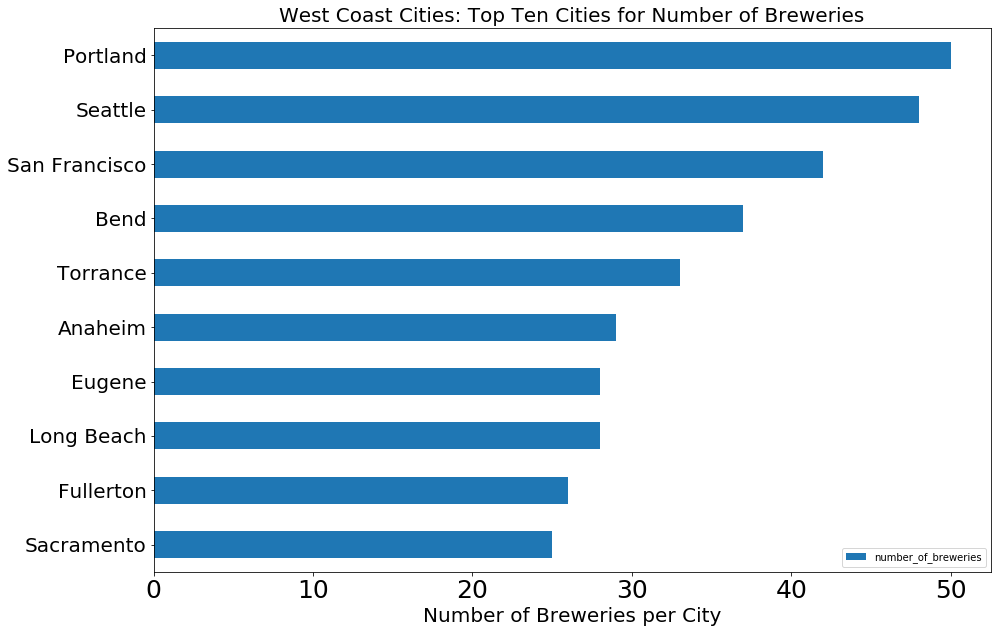

In [243]:
#plot data
import matplotlib.pyplot as plt
brewery_count_top.plot(kind='barh', figsize=(15, 10))

plt.xlabel('Number of Breweries per City',fontsize=20) # add to x-label to the plot
#plt.ylabel('City Name', fontsize=20) # add y-label to the plot
plt.title('West Coast Cities: Top Ten Cities for Number of Breweries', fontsize=20) # add title to the plot
plt.yticks([s for s in range(len(brewery_count_top))], brewery_count_top.city, fontsize=20)
plt.xticks(fontsize=25)

plt.show()

In [194]:
# repeat with full results
brewery_count = city_breweries[['city', 'number_of_breweries']]
brewery_count = brewery_count.sort_values(['number_of_breweries'], ascending=True).reset_index(drop=True)
brewery_count[::-1].head()

,city,number_of_breweries
137,Portland,50
136,Seattle,48
135,San Francisco,42
134,Bend,37
133,Torrance,33


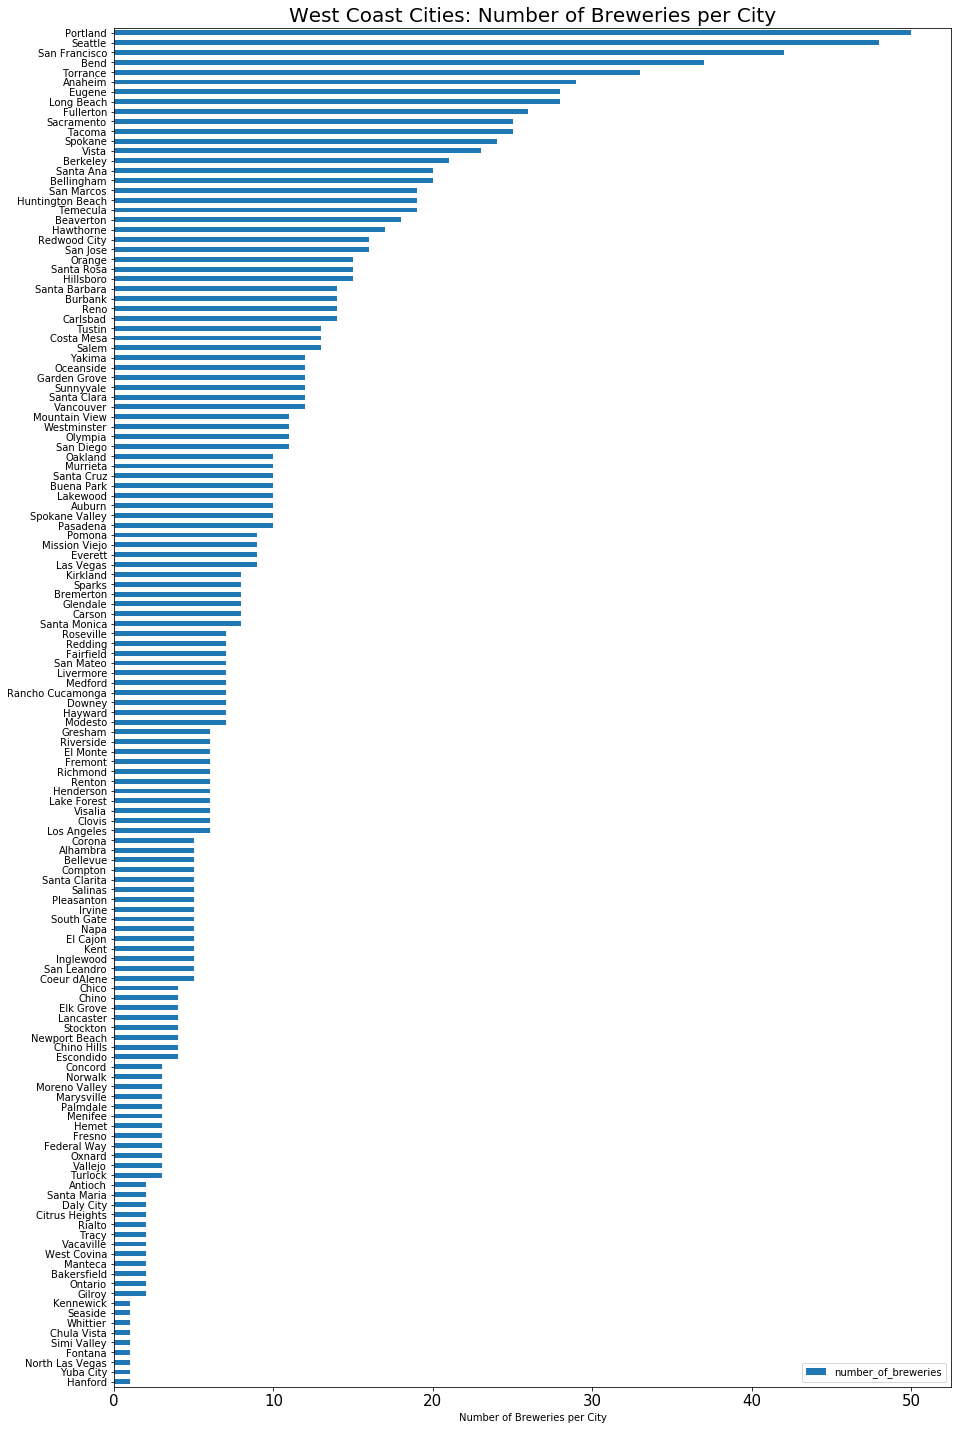

In [208]:
#plot data
import matplotlib.pyplot as plt
brewery_count.plot(kind='barh', figsize=(15, 25))

plt.xlabel('Number of Breweries per City',fontsize=10) # add to x-label to the plot
#plt.ylabel('City Name', fontsize=20) # add y-label to the plot
plt.title('West Coast Cities: Number of Breweries per City', fontsize=20) # add title to the plot
plt.yticks([s for s in range(len(brewery_count))], brewery_count.city, fontsize=10)
plt.xticks(fontsize=15)

plt.show()

## Number of Breweries:
Clearly we have a West Coast winner for number of breweries.  But that doesn't take into account the size of that city, as we do next.  Rather than the hard-to-grasp decimals, we'll state the results per 100,000 residents:

In [244]:
percapita_breweries = city_breweries[['city', 'breweries_per_100k']]
percapita_breweries = percapita_breweries.sort_values(['breweries_per_100k'], ascending=True).reset_index(drop=True)
percapita_breweries_top = percapita_breweries.tail(10)

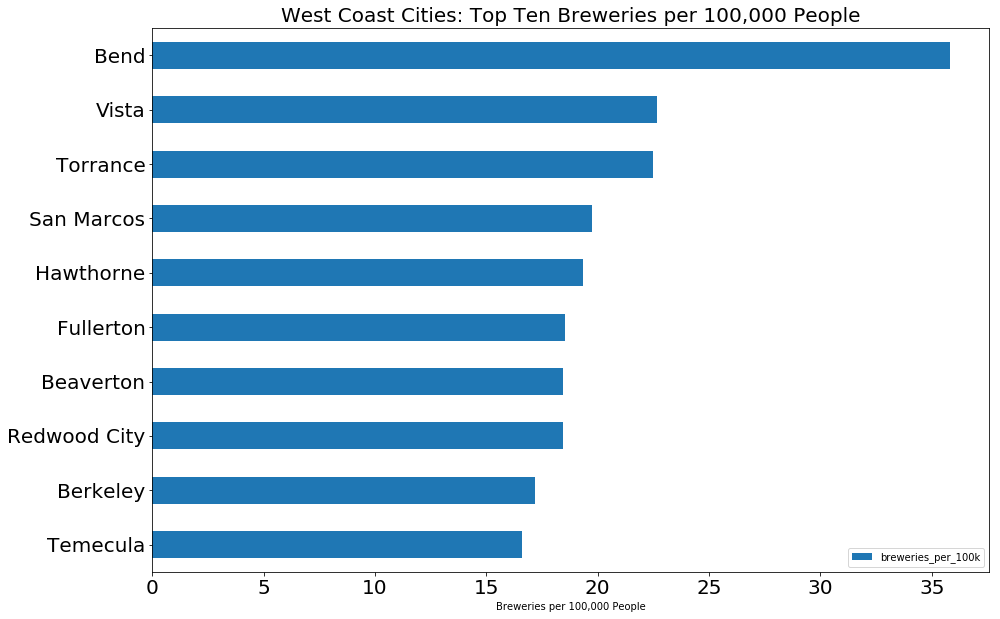

In [246]:
#plot the top ten
import matplotlib.pyplot as plt
percapita_breweries_top.plot(kind='barh', figsize=(15, 10))

plt.xlabel('Breweries per 100,000 People',fontsize=10) # add to x-label to the plot
#plt.ylabel('City Name', fontsize=20) # add y-label to the plot
plt.title('West Coast Cities: Top Ten Breweries per 100,000 People', fontsize=20) # add title to the plot
plt.yticks([s for s in range(len(percapita_breweries_top))], percapita_breweries_top.city, fontsize=20)
plt.xticks(fontsize=20)


plt.show()

#### Show the full data set:

In [247]:
percapita_breweries = city_breweries[['city', 'breweries_per_100k']]
percapita_breweries = percapita_breweries.sort_values(['breweries_per_100k'], ascending=True).reset_index(drop=True)

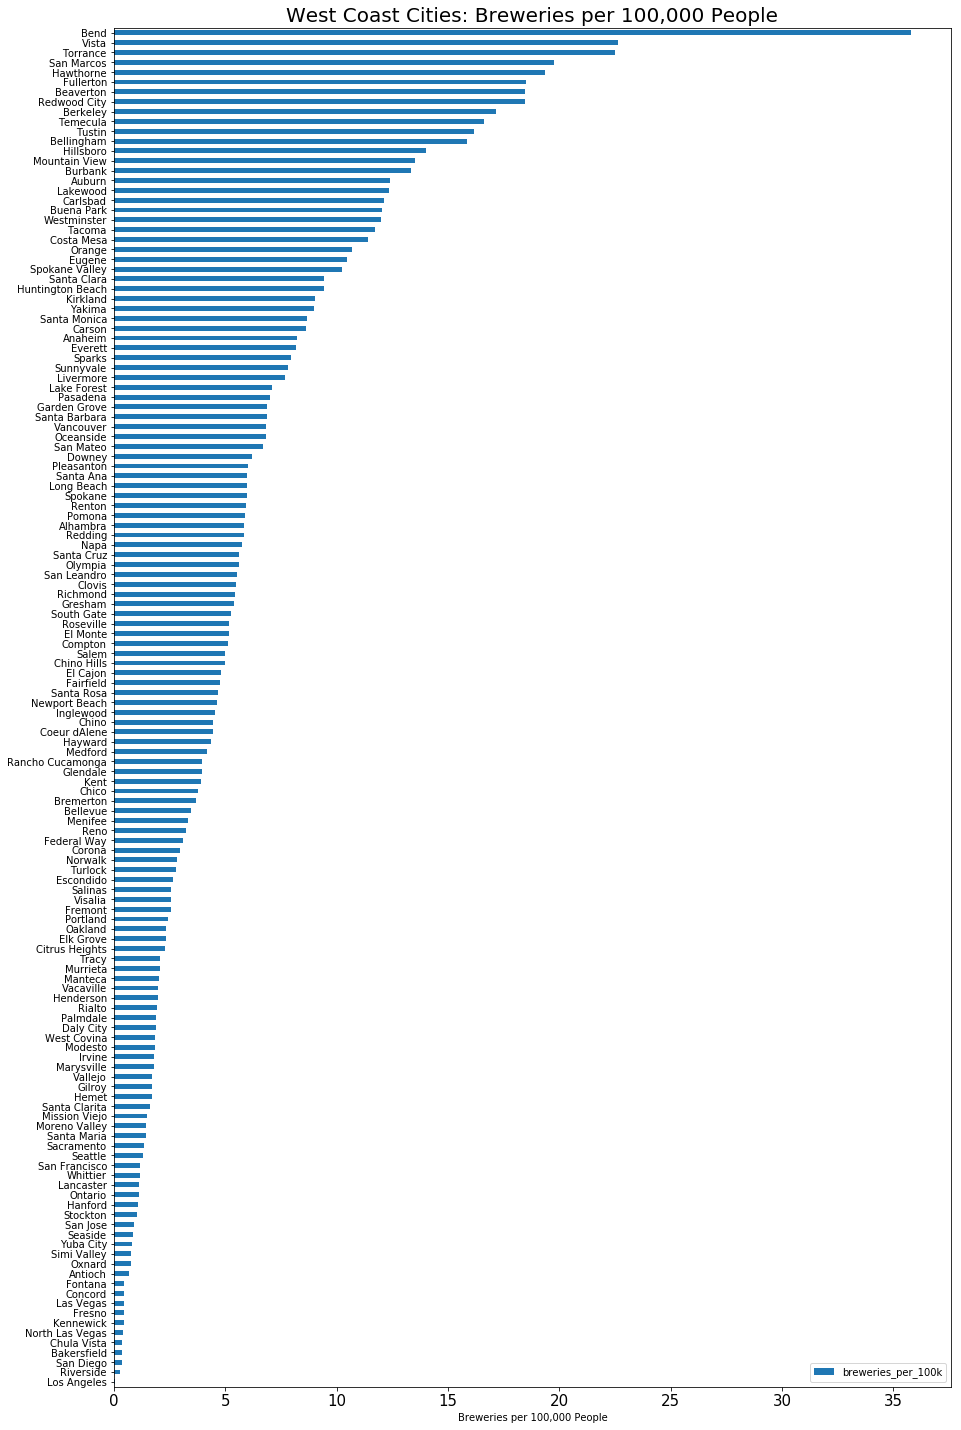

In [248]:
#plot data
import matplotlib.pyplot as plt
percapita_breweries.plot(kind='barh', figsize=(15, 25))

plt.xlabel('Breweries per 100,000 People',fontsize=10) # add to x-label to the plot
#plt.ylabel('City Name', fontsize=20) # add y-label to the plot
plt.title('West Coast Cities: Breweries per 100,000 People', fontsize=20) # add title to the plot
plt.yticks([s for s in range(len(percapita_breweries))], percapita_breweries.city, fontsize=10)
plt.xticks(fontsize=15)


plt.show()

# Conclusion
Now we have answered the question we set out for.  If we want to move to a city that has plenty of Breweries to go around, we can use the Bar Chart above to make our choice.

As you might imagine, **Portland, Seattle, and San Francisco are the top three cities in terms of Number of Breweries**.  But they are also quite populated cities.  

If you're looking for your **most breweries per capita, then Bend, Oregon** is your place.  (I have enjoyed their suds before and it's excellent, particularly Mirror Pond Pale Ale from [Deschutes Brewery](https://www.deschutesbrewery.com/beer/mirror-pond-pale-ale/). 

After that, head to Southern California where the next five 'densest' brewery zones exist.

### Limitations:
The search for breweries started with city populations, *then* looked for breweries.  This does not take into account breweries outside of city limits, or breweries straddling various city limits.

# Next Steps

When I have time to work further on this project, I will go after the following:

* compare large to small cities
* use foursquare to get ALL breweries in USA.  
* use DBSCAN Density Based Clustering to find most densely breweried neighborhoods

